# Making a dataset with bcolz array

We are going to do preprocessing and preparation of a large set of images converting them to numpy arrays which can then be saved as a bcolz array

https://bcolz.readthedocs.io/en/latest/

bcolz provides columnar, chunked data containers that can be compressed either in-memory and on-disk. Column storage allows for efficiently querying tables, as well as for cheap column addition and removal. It is based on NumPy, and uses it as the standard data container to communicate with bcolz objects, but it also comes with support for import/export facilities to/from HDF5/PyTables tables and pandas dataframes.


https://bcolz.readthedocs.io/en/latest/intro.html#bcolz-at-glance

In [ ]:
!pwd
#!ls

#install if you dont have this package
!pip install python-resize-image

In [1]:
%matplotlib inline
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import keras
import keras.backend as K

import cv2
from PIL import Image
import random
import glob
import pickle
from keras.preprocessing.image import load_img, img_to_array

from resizeimage import resizeimage
from scipy.misc import imsave

import bcolz
import threading
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
from time import sleep



Using TensorFlow backend.


## Setting the Paths

In [3]:
#The dir that has the images we want to put into the array
DATA_PATH = '/Users/samwitteveen/dropbox/ai_learning/dl_dev_course/nbs/data/img_align_celeba/'

# Where to save our new data
SAVE_PATH = '/Users/samwitteveen/dropbox/ai_learning/dl_dev_course/nbs/data/'

## Get the file names from the direcctory and then save it as a list

In [4]:
# Save image filenames
fnames = list(glob.iglob(DATA_PATH+'*.jpg'))
fnames.sort()
pickle.dump(fnames, open(DATA_PATH+'fnamesfullpath.p', 'wb'))
fnames = pickle.load(open(DATA_PATH+'fnamesfullpath.p', 'rb'))

len(fnames)
fnames = fnames[0:50000]
len(fnames)

50000

In [5]:
fnames[10]

'/Users/samwitteveen/dropbox/ai_learning/dl_dev_course/nbs/data/img_align_celeba/000011.jpg'

### Example Resizing function

Load the image and resize it to the size we want

We can also put any normalization we want to in this 

In [50]:
#center cropping ?? no
new_s = 76 # The HxW of the image 

def _resize(img):
    shortest = min(img.width,img.height)
    resized = np.round(np.multiply(new_s/shortest, img.size)).astype(int)
    return img.resize(resized, Image.BILINEAR)

def resize_img(file_path):
    img = Image.open(file_path)
    #img = np.array(np.mean(img, -1))
    s = np.array(img).shape
    if len(s)!=3 or s[2]!=3: 
        return
    return _resize(img)


### Show an image

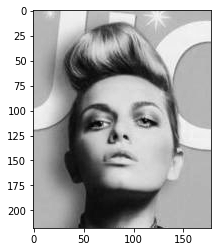

In [51]:
img = Image.open(fnames[4])
img = np.mean(img, -1)

imgplot = plt.imshow(img/255., cmap='gray')

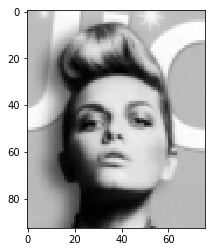

In [52]:
#img = Image.open(fnames[4])

img = resize_img(fnames[4])
img = np.array(np.mean(img, -1))
imgplot = plt.imshow(img/255., cmap='gray')

## Put images into a bcolz array

In [53]:
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

In [14]:
#New bcolz
bcolz_file_path = './demo_bcolz_arr.bc'

NEW_SIZE = 176 #h x w to resize to

#### Create the bcolz array

In [16]:
arr_hr = bcolz.carray(np.empty((0, NEW_SIZE, NEW_SIZE, 3), 'float32'), chunklen=16, mode='w', rootdir=bcolz_file_path)

In [17]:
#Pre-allocate memory
tl = threading.local()
tl.place = np.zeros((NEW_SIZE,NEW_SIZE,3), 'uint8')

### We can put a variety of preprocessing the function to resize and change the images

We pass in the pre-initialized bcolz array and the filenames

In [18]:
def make_bcolz(arr,fnames):
    for name in fnames:
        # Open the image
        img = Image.open(name)
        
        # Change to Grayscale
        #img = cv2.cvtColor( img, cv2.COLOR_RGB2GRAY )
        
        # Resize
        cover = resizeimage.resize_cover(img, [NEW_SIZE, NEW_SIZE])
        
        # Convert to numpy array
        a = np.asarray(cover)
        
        # Normalize to between 0-1
        #a = a/255.
        
        arr.append(a)
        
make_bcolz(arr_hr,fnames)

#flush saves it all to disk
arr_hr.flush()

# Check the shape
arr_hr.shape


(50000, 176, 176, 3)

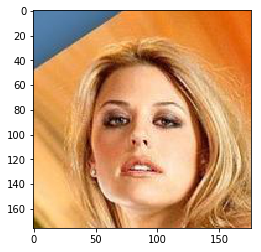

In [19]:
imgplot = plt.imshow(arr_hr[23]/255.)

# Make the blurred images array

In [ ]:
#New bcolz
bcolz_file_path = './celeba-blur_50k.bc'

NEW_SIZE = 176 #h x w to resize to

In [ ]:
arr_blur = bcolz.carray(np.empty((0, NEW_SIZE, NEW_SIZE, 3), 'float32'), chunklen=16, mode='w', rootdir=bcolz_file_path)

In [ ]:
def make_blur_bcolz(arr,fnames):
    for name in fnames:
        img = Image.open(name)
        #img = cv2.cvtColor( img, cv2.COLOR_RGB2GRAY )
        cover = resizeimage.resize_cover(img, [NEW_SIZE, NEW_SIZE])
        kernel = np.ones((5,5),np.float32)/25
        
        np_image = np.asarray(cover)
        np_image = cv2.filter2D(np_image,-1,kernel)

        ##print(a.shape)
        arr.append(np_image)
        
make_blur_bcolz(arr_blur,fnames)
arr_blur.flush()
arr_blur.shape

In [ ]:
new_blur = load_array(bcolz_file_path)
new_blur.shape

In [ ]:
imgplot = plt.imshow(new_blur[23]/255.)

In [ ]:
imgplot = plt.imshow(new_blur[13]/255.)